In [59]:
import pandas as pd

# Read test and training set 
test_data = pd.read_csv('data/test.csv')
train_data = pd.read_csv('data/train.csv')

First of all have a brief look at the data. Understand the structure of the data. 

In [60]:
train_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


I'll do Data Cleaning first. Exclude columns that I won't use, handle missing values.

In [61]:
columns_to_exclude = ['Ticket']
train_data_cleaned = train_data.drop(columns=columns_to_exclude)

# Check missing values 
missing_values_count = train_data_cleaned.isnull().sum()
missing_values_count[0:10]

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Cabin          687
dtype: int64

Dealing with missing values. For embarked we only have 2 missing values, so I am going to put the most common port of embarkation here. For age I could use mean value based on gender and fill it in. This seems to be the most natural solution. More than half the values for Cabin are missing. I could remove this column, but the missing information may be useful later in the feature engineering phase. 

In [62]:
# Calculate average age for males and females
average_male_age = train_data[train_data['Sex'] == 'male']['Age'].mean()
average_female_age = train_data[train_data['Sex'] == 'female']['Age'].mean()

# Fill missing values in 'Age' based on gender
train_data_cleaned['Age'] = train_data_cleaned.apply(
    lambda row: average_male_age if pd.isnull(row['Age']) and row['Sex'] == 'male' else
                  average_female_age if pd.isnull(row['Age']) and row['Sex'] == 'female' else
                  row['Age'],
    axis=1
)

# Fill missing values in 'Embarked' with 'C', which is the most common cabin 
train_data_cleaned['Embarked'].fillna('C', inplace=True)

In [63]:
sex_encoded = pd.get_dummies(train_data['Sex'], prefix='Sex', drop_first=True)

train_data_cleaned['Sex'] = sex_encoded['Sex_male']
train_data_cleaned.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",True,22.0,1,0,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",False,38.0,1,0,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",False,26.0,0,0,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",False,35.0,1,0,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",True,35.0,0,0,8.0500,NaN,S


# Feature engineering 
First look at the cleaned data again. Plot the data to see relationships and patterns. 

In [64]:
train_data_cleaned.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.736034,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.014897,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The first thing I want to look at is the difference in survival between men and women. Plot the graph showing the number of surviving males and females.

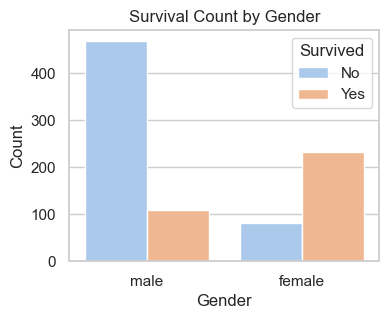

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a count plot
plt.figure(figsize=(4, 3))
sns.countplot(x='Sex', hue='Survived', data=train_data, palette='pastel')

# Add labels and title
plt.title('Survival Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

# Add legend
plt.legend(title='Survived', loc='upper right', labels=['No', 'Yes'])

# Show the plot
plt.show()



The first thing  I would like to do that would help me to create new features is to have a look at titles extracted from names. We know that women tend to survive more, but I can assume that women with the title Mrs could survive more. I remember from the data cleaning stage that we had a lot of missing values in the Cabin column. It may be useful to create a new feature based on whether the 'Cabin' information is present or absent (NaN).

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64


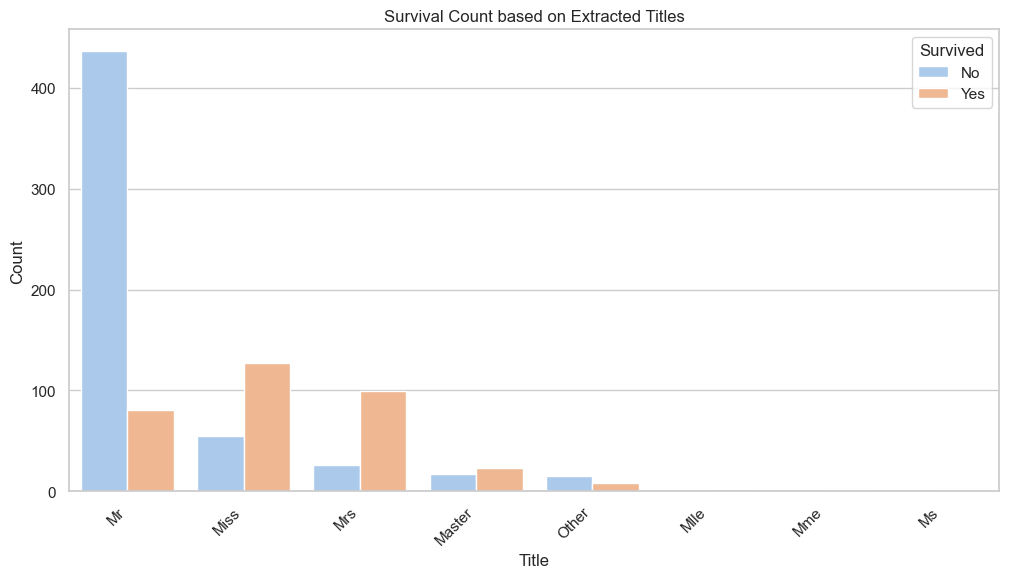

In [66]:
# Extract titles from the 'Name' column
train_data_cleaned['Title'] = train_data_cleaned['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Display unique titles and their counts
print(train_data_cleaned['Title'].value_counts())

# Combine less common titles into a general category
train_data_cleaned['Title'] = train_data_cleaned['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Capt', 'Countess', 'Lady', 'Sir', 'Jonkheer', 'Don', 'Dona'], 'Other')

# Encoding of the Cabin column 
train_data_cleaned['Cabin_Present'] = train_data_cleaned['Cabin'].notnull().astype(int)

plt.figure(figsize=(12, 6))
sns.countplot(x='Title', hue='Survived', data=train_data_cleaned, palette='pastel', order=train_data_cleaned['Title'].value_counts().index)

# Add labels and title
plt.title('Survival Count based on Extracted Titles')
plt.xlabel('Title')
plt.ylabel('Count')

# Add legend
plt.legend(title='Survived', loc='upper right', labels=['No', 'Yes'])

# Show the plot
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

We can see that females with the title Miss tend to survive more. I can create a new feature related to titles, as there are mostly Mr, Miss and Mr titles, I will use the values 0, 1, 2, 3 to encode these titles and others. I would also chech if the title is rare as passengers with rare titles tend to survive more. 

In [67]:
title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2}
train_data_cleaned['Title_Encoded'] = train_data_cleaned['Title'].map(title_mapping).fillna(3).astype(int)

# Feature indicating marital status
train_data_cleaned['Married'] = (train_data_cleaned['Title'] == 'Mrs').astype(int)

# Identify rare titles
rare_titles = train_data_cleaned['Title'].value_counts()[train_data_cleaned['Title'].value_counts() < 10].index
train_data_cleaned['Is_Rare_Title'] = train_data_cleaned['Title'].isin(rare_titles).astype(int)

The next step is to have a look at the distribution of the fares. From describe() I already have some understanding of what the mean value for fares is. I can see that there are some outliers that are heavily skewing the data. I will remove them and plot the graph.

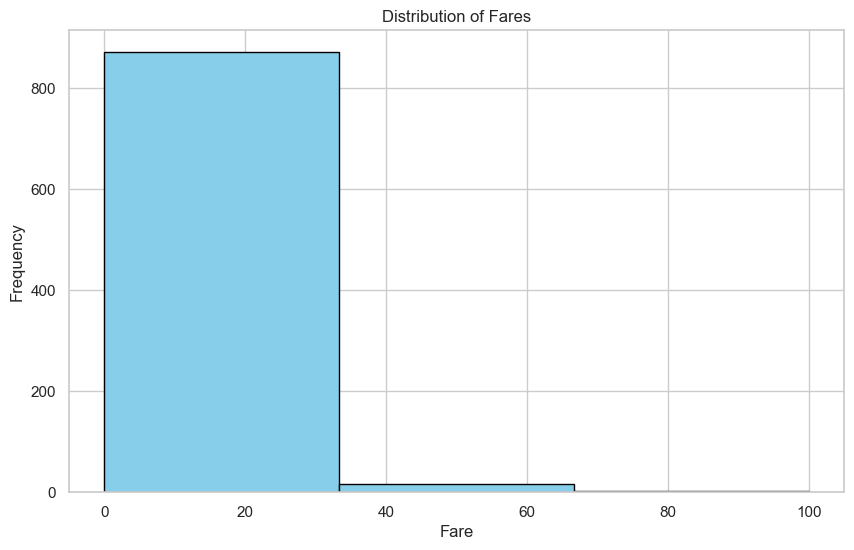

In [68]:

# Perform Min-Max normalization for 'Fare' column
min_fare = train_data_cleaned['Fare'].min()
max_fare = train_data_cleaned['Fare'].max()
train_data_cleaned['Normalized_Fare'] = 100 * (train_data_cleaned['Fare'] - min_fare) / (max_fare - min_fare)

# Create a histogram for fares
plt.figure(figsize=(10, 6))
plt.hist(train_data_cleaned['Normalized_Fare'], bins=3, color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Distribution of Fares')
plt.xlabel('Fare')
plt.ylabel('Frequency')

# Show the plot
plt.show()

I will do 3 categories based on fares and create a new feature. 

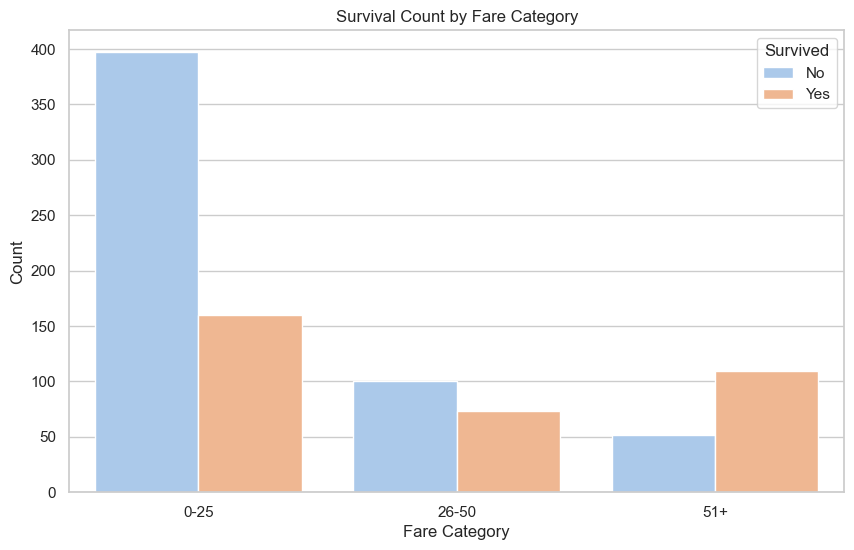

In [69]:
# Define bins for fare categories
fare_bins = [0, 25, 50, float('inf')]
fare_labels = ['0-25', '26-50', '51+']

# Create a new column 'Fare_Category' based on fare bins
train_data_cleaned['Fare_Category'] = pd.cut(train_data_cleaned['Fare'], bins=fare_bins, labels=fare_labels, right=False)
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.countplot(x='Fare_Category', hue='Survived', data=train_data_cleaned, palette='pastel')

# Add labels and title
plt.title('Survival Count by Fare Category')
plt.xlabel('Fare Category')
plt.ylabel('Count')

# Add legend
plt.legend(title='Survived', loc='upper right', labels=['No', 'Yes'])

# Show the plot
plt.show()

fare_category_mapping = {'0-25' : 0, '26-50' : 1, '51+' : 2}
train_data_cleaned['Fare_Category'] = train_data_cleaned['Fare_Category'].map(fare_category_mapping)


Parch and SibSp analysis. I can create new features based on whether someone has sibling/parents. It would be good to see if someone is alone. Categorising family size can also be useful.

In [70]:
# Create 'Family_Size' feature
train_data_cleaned['Family_Size'] = train_data_cleaned['Parch'] + train_data_cleaned['SibSp']

# Create 'Is_Alone' feature
train_data_cleaned['Is_Alone'] = (train_data_cleaned['Family_Size'] == 0).astype(int)

# Categorize passengers into different family types
def categorize_family_size(size):
    if size == 0:
        return 0
    elif size <= 3:
        return 1
    elif size <= 6:
        return 2
    else:
        return 3

train_data_cleaned['Family_Type'] = train_data_cleaned['Family_Size'].apply(categorize_family_size)

# Create 'Is_Parent' feature
train_data_cleaned['Is_Parent'] = (train_data_cleaned['Parch'] > 0).astype(int)

# Create 'Is_Child' feature
train_data_cleaned['Is_Child'] = (train_data_cleaned['Age'] < 18).astype(int)

# Drop Cabin colimn as it has to many NaN values 
train_data_cleaned = train_data_cleaned.drop(columns=['Name', 'Cabin', 'Title', 'Embarked'])

train_data_cleaned.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_Present,Title_Encoded,Married,Is_Rare_Title,Normalized_Fare,Fare_Category,Family_Size,Is_Alone,Family_Type,Is_Parent,Is_Child
0,1,0,3,True,22.0,1,0,7.2500,0,0,0,0,1.415106,0,1,0,1,0,0
1,2,1,1,False,38.0,1,0,71.2833,1,2,1,0,13.913574,2,1,0,1,0,0
2,3,1,3,False,26.0,0,0,7.9250,0,1,0,0,1.546857,0,0,1,0,0,0
3,4,1,1,False,35.0,1,0,53.1000,1,2,1,0,10.364430,2,1,0,1,0,0
4,5,0,3,True,35.0,0,0,8.0500,0,0,0,0,1.571255,0,0,1,0,0,0


# Model selection and model training
After data is prepared I am going to have a look at different models and compare their perfomance. Tune the parameters to get better results. As I have a lot of encoded data I am going to use Random Forest classifier. 

In [71]:
train_data_cleaned.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Cabin_Present', 'Title_Encoded', 'Married', 'Is_Rare_Title',
       'Normalized_Fare', 'Fare_Category', 'Family_Size', 'Is_Alone',
       'Family_Type', 'Is_Parent', 'Is_Child'],
      dtype='object')

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pipeline

# Define features and target variable
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
            'Fare', 'Cabin_Present', 'Title_Encoded', 'Married',
            'Is_Rare_Title', 'Normalized_Fare', 'Fare_Category', 'Family_Size',
            'Is_Alone', 'Family_Type', 'Is_Parent', 'Is_Child']
target = 'Survived'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    train_data_cleaned[features],
    train_data_cleaned[target],
    test_size=0.2,
    random_state=42
)

# Create a Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)

# Define hyperparameters and their potential values for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Use Grid Search to find the best combination of hyperparameters
grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_random_forest_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_random_forest_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy with Best Model: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy with Best Model: 0.8380
Confusion Matrix:
[[93 12]
 [17 57]]


/Users/minimuh322/miniconda3/envs/study/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
287 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/minimuh322/miniconda3/envs/study/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/minimuh322/miniconda3/envs/study/lib/python3.11/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/Users/minimuh322/miniconda3/envs/study/lib/python3.11/site-packages/sklearn/base.py", line 666,

In [75]:
cleaned_data = pipeline.cleaning(test_data)
X_test_processed = pipeline.fearure_engineering(cleaned_data)
y_pred_test = best_random_forest_model.predict(X_test_processed[features])

# Create a DataFrame with PassengerId and Predicted Survived
submission_df = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': y_pred_test})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)